# Description

A simple model that predicts which stock in a pair will have higher return on
the next day.


# Versions
## v1
- Context window: 8 days price history
- Logistic model predicts which stock has higher return on the next day
- Naive strategy of holding the stock with predicted higher return
- Table comparing return vs baselines: always hold either stock in the pair

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from matplotlib import pyplot as plt

%matplotlib inline

import pandas as pd
import torch as th
import numpy as np

plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

# Dataset

In [48]:
from data import daily_df
from data import date_range

batch_size = 128
hist_win = 8

train_date_range = date_range.DateRange('2003-01-01', '2017-01-01')
eval_date_range = date_range.DateRange('2017-01-01', '2020-01-01')

In [84]:
tickers = ('GOOG', 'AAPL', 'MSFT')
num_tickers = len(tickers)

def load_df(tickers, date_range):
  cfg = daily_df.Cfg(tickers=tickers)
  df = daily_df.load_df(cfg, date_range)
  print(f'Loaded {len(df)} days.')
  df = df.dropna(how='any').reset_index(drop=True)
  print(f'Kept {len(df)} days.')
  return df

df_train = load_df(tickers, train_date_range)
df_valid = load_df(tickers, eval_date_range)

Loaded 3525 days.
Kept 3115 days.
Loaded 754 days.
Kept 754 days.


In [85]:
df_train.head(5)

,date,GOOG_volume,GOOG_open,GOOG_high,GOOG_low,GOOG_close,GOOG_adjclose,AAPL_volume,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_adjclose,MSFT_volume,MSFT_open,MSFT_high,MSFT_low,MSFT_close,MSFT_adjclose
0,2004-08-19,44871300.0,49.813286,51.835709,47.800831,49.982655,49.982655,97230000,2.250714,2.275714,2.168571,2.193571,1.898969,46293000,27.350000,27.450001,27.010000,27.120001,17.505459
1,2004-08-20,22942800.0,50.316402,54.336334,50.062355,53.952770,53.952770,79195200,2.193571,2.213571,2.177857,2.200000,1.904534,46494800,27.129999,27.370001,27.040001,27.200001,17.557100
2,2004-08-23,18342800.0,55.168217,56.528118,54.321388,54.495735,54.495735,63665000,2.204286,2.233572,2.185714,2.220000,1.921849,39572200,27.270000,27.330000,27.120001,27.240000,17.634779
3,2004-08-24,15319700.0,55.412300,55.591629,51.591621,52.239193,52.239193,93534000,2.232857,2.282143,2.227857,2.282143,1.975645,40835300,27.400000,27.459999,27.090000,27.240000,17.634779
4,2004-08-25,9232100.0,52.284027,53.798351,51.746044,52.802086,52.802086,126404600,2.276428,2.367857,2.266428,2.360714,2.043664,53512700,27.209999,27.670000,27.180000,27.549999,17.835468


In [86]:
df_train.tail(5)

,date,GOOG_volume,GOOG_open,GOOG_high,GOOG_low,GOOG_close,GOOG_adjclose,AAPL_volume,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_adjclose,MSFT_volume,MSFT_open,MSFT_high,MSFT_low,MSFT_close,MSFT_adjclose
3110,2016-12-23,623400.0,790.900024,792.739990,787.280029,789.909973,789.909973,14249500,115.589996,116.519997,115.589996,116.519997,110.743988,12403800,63.450001,63.540001,62.799999,63.240002,59.590977
3111,2016-12-27,789100.0,790.679993,797.859985,787.656982,791.549988,791.549988,18296900,116.519997,117.800003,116.489998,117.260002,111.447319,11763200,63.209999,64.070000,63.209999,63.279999,59.628666
3112,2016-12-28,1153800.0,793.700012,794.229980,783.200012,785.049988,785.049988,20905900,117.519997,118.019997,116.199997,116.760002,110.972122,14653300,63.400002,63.400002,62.830002,62.990002,59.355404
3113,2016-12-29,744300.0,783.330017,785.929993,778.919983,782.789978,782.789978,15039500,116.449997,117.110001,116.400002,116.730003,110.943588,10250600,62.860001,63.200001,62.730000,62.900002,59.270599
3114,2016-12-30,1770000.0,782.750000,782.780029,770.409973,771.820007,771.820007,30586300,116.650002,117.199997,115.430000,115.820000,110.078697,25579900,62.959999,62.990002,62.029999,62.139999,58.554443


In [87]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from data import daily_dataset

PRICE_REPR = daily_dataset.PriceRepr.RETURN

def create_ds_dl(df, tickers, price_repr=PRICE_REPR):
  ds = daily_dataset.StockSeqDataset(
    df=df,
    cols=[f'{ticker}_adjclose' for ticker in tickers],
    window_size=hist_win + 1,
    price_repr=price_repr)

  ds_multistock = daily_dataset.MultiStockSelectionDataset(ds)
  dl_multistock = DataLoader(dataset=ds_multistock, batch_size=batch_size,
                            shuffle=True)
  return ds_multistock, dl_multistock

ds_train, dl_train = create_ds_dl(df_train, tickers)
ds_valid, dl_valid = create_ds_dl(df_valid, tickers)

In [88]:
print(len(ds_train), len(dl_train))
print(len(ds_valid), len(dl_valid))

3106 25
745 6


In [89]:
ds_train[0]

{'x': tensor([[1.0794, 1.0029, 1.0030],
         [1.0101, 1.0091, 1.0044],
         [0.9586, 1.0280, 1.0000],
         [1.0108, 1.0344, 1.0114],
         [1.0180, 1.0487, 0.9960],
         [0.9837, 0.9911, 1.0007],
         [0.9610, 0.9933, 0.9942],
         [1.0035, 1.0108, 1.0000]]),
 'y': tensor([0.9793, 1.0397, 1.0033]),
 'label': tensor(1)}

In [90]:
for batch in dl_train:
    print({k: t.shape for k, t in batch.items()})
    break

{'x': torch.Size([128, 8, 3]), 'y': torch.Size([128, 3]), 'label': torch.Size([128])}


# Model

In [91]:
class MultiStockSelector(th.nn.Module):
  def __init__(self, num_tickers, hist_win):
    super().__init__()
    self.ff = th.nn.Sequential(
      th.nn.LayerNorm(num_tickers * hist_win),
      th.nn.Linear(num_tickers * hist_win, 1000),
      th.nn.Sigmoid(),
      th.nn.Linear(1000, 1000),
      # th.nn.ReLU(),
      th.nn.Sigmoid(),
      th.nn.Linear(1000, num_tickers),
    )
    self.apply(self.init_)

  def init_(self, m):
    if isinstance(m, th.nn.Linear):
      th.nn.init.xavier_normal_(m.weight)
      th.nn.init.constant_(m.bias, 0.0)
    
  def forward(self, x):
    x = x.view(x.shape[0], -1)  # [b, t * n_tickers]
    logits = self.ff(x)
    return logits
    

model = MultiStockSelector(num_tickers=num_tickers, hist_win=hist_win)
loss_fn = th.nn.CrossEntropyLoss()

learning_rate = 3e-4
optimizer = th.optim.Adam(model.parameters(), lr=learning_rate)
lr_schedule = th.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)


def eval(model, dl):
  model.eval()
  with th.no_grad():
    loss_avg = 0
    epoch_accuracy = 0
    assert PRICE_REPR == daily_dataset.PriceRepr.RETURN
    log_return = 0
    base_log_return = [0] * num_tickers
    oracle_log_return = 0
    for batch in dl:
        x = batch['x']
        label = batch['label']
        logits = model(x)
        loss = loss_fn(logits, label)
        loss_avg += loss.item()
        preds = th.argmax(logits, axis=-1)
        accuracy = (label == preds).sum().item() / label.shape[0]
        epoch_accuracy += accuracy
        y = batch['y']
        day_return = y[np.arange(y.shape[0]), preds]
        log_return += day_return.log().sum()
        for i in range(num_tickers):
          ret = y[:, i]
          base_log_return[i] += ret.log().sum()
        oracle = y.max(dim=-1)[0]
        oracle_log_return += oracle.log().sum()
    print(f'valid loss: {loss_avg / len(dl):.4f}; '
          f'accuracy: {100 * epoch_accuracy / len(dl):.2f}%; '
          f'total_return: {log_return.exp():.2f}; ' +
          ''.join(
            f'{tickers[i]}_return: {base_log_return[i].exp():.2f}; '
            for i in range(num_tickers)
          ) +
          f'oracle_return: {oracle_log_return.exp():.2f}; '
    )
  model.train()


epochs = 100
for epoch in range(epochs):
    loss_avg = 0
    epoch_accuracy = 0
    log_return = 0
    for batch in dl_train:
        x = batch['x']
        label = batch['label']
        logits = model(x)
        loss = loss_fn(logits, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_avg += loss.item()
        preds = th.argmax(logits, axis=-1)
        accuracy = (label == preds).sum().item() / label.shape[0]
        epoch_accuracy += accuracy
    lr_schedule.step()
    print(f'epoch: {epoch}; '
          f'lr: {lr_schedule.get_last_lr()[0]:.5f}; '
          f'train loss: {loss_avg / len(dl_train):.4f}; '
          f'accuracy: {100 * epoch_accuracy / len(dl_train):.2f}%; ')
    eval(model, dl_train)
    eval(model, dl_valid)

epoch: 0; lr: 0.00027; train loss: 1.1498; accuracy: 33.65%; 
valid loss: 1.0997; accuracy: 37.18%; total_return: 51.61; GOOG_return: 15.14; AAPL_return: 51.61; MSFT_return: 3.31; oracle_return: 2666539572527104.00; 
valid loss: 1.1071; accuracy: 37.79%; total_return: 2.58; GOOG_return: 1.65; AAPL_return: 2.58; MSFT_return: 2.65; oracle_return: 275.39; 
epoch: 1; lr: 0.00024; train loss: 1.1103; accuracy: 34.99%; 
valid loss: 1.1065; accuracy: 31.77%; total_return: 3.34; GOOG_return: 15.14; AAPL_return: 51.61; MSFT_return: 3.31; oracle_return: 2666539572527104.00; 
valid loss: 1.0989; accuracy: 34.32%; total_return: 3.28; GOOG_return: 1.65; AAPL_return: 2.58; MSFT_return: 2.65; oracle_return: 275.39; 
epoch: 2; lr: 0.00022; train loss: 1.1061; accuracy: 34.79%; 
valid loss: 1.1119; accuracy: 30.49%; total_return: 3.34; GOOG_return: 15.14; AAPL_return: 51.61; MSFT_return: 3.31; oracle_return: 2666549773074432.00; 
valid loss: 1.1025; accuracy: 33.33%; total_return: 2.65; GOOG_return: 1.

In [60]:
model(x).max(dim=-1)

torch.return_types.max(
values=tensor([0.1315, 0.1694, 0.1629, 0.1456, 0.1294, 0.1570, 0.1191, 0.1005, 0.1490,
        0.1028, 0.1706, 0.1720, 0.1184, 0.1248, 0.1627, 0.1207, 0.2032, 0.1826,
        0.1369, 0.1216, 0.1357, 0.1085, 0.2238, 0.1274, 0.1441, 0.1158, 0.1075,
        0.1660, 0.1110, 0.1621, 0.1274, 0.1285, 0.1119, 0.1093],
       grad_fn=<MaxBackward0>),
indices=tensor([0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 0]))

# Baseline Models

In [14]:
class MeanModel(th.nn.Module):
    def forward(self, x):
        return x.mean(dim=-1).unsqueeze(axis=1)

# Validation

In [15]:
list(model.parameters())

[Parameter containing:
 tensor([1.0072, 0.9983, 0.9951, 0.9937, 0.9995, 0.9958, 1.0084, 1.0118, 1.0018,
         1.0082, 0.9956, 1.0028, 1.0034, 1.0037, 1.0129, 0.9977, 1.0057, 1.0019,
         1.0021, 1.0029, 1.0123, 0.9954, 0.9995, 1.0033, 1.0090, 1.0090, 1.0045,
         0.9979, 1.0014, 1.0018, 1.0158, 0.9946, 0.9968, 1.0017, 1.0081, 1.0013,
         1.0097, 1.0055, 0.9983, 1.0021], requires_grad=True),
 Parameter containing:
 tensor([ 8.7273e-04,  1.3998e-04,  3.2616e-03, -2.6352e-03,  4.2480e-04,
          5.3487e-03, -7.0587e-04, -1.3544e-04,  3.7111e-04,  5.5808e-04,
         -2.0742e-03,  2.5918e-04,  3.5318e-05, -2.7782e-05, -9.5479e-05,
         -2.8290e-04, -8.8448e-04,  1.5884e-03,  1.6893e-03,  5.0392e-04,
          5.2087e-04, -1.1201e-03, -1.0284e-04, -2.8480e-04, -1.0747e-03,
          1.1952e-03,  3.0020e-03,  3.1347e-03,  1.5387e-04,  1.6335e-04,
          5.6688e-04,  9.5775e-04,  4.1954e-03, -1.1701e-04,  2.9016e-04,
          2.0876e-03, -2.4469e-04,  2.0847e-04,  

In [16]:
def validate(model, ticker):
  assert pred_win == 1
  df = load_df(ticker, eval_date_range)
  ds = StockSeqDataset(df)
  dl = DataLoader(dataset=ds, batch_size=batch_size, shuffle=False)
  for i, (x, y) in enumerate(dl):
    start = batch_size * i + hist_win  # prediction is offset by hist_win
    end = start + batch_size - 1  # slice end is inclusive
    with th.no_grad():
      y_pred = model(x)
    y = y.cpu().numpy().squeeze()
    y_pred = y_pred.cpu().numpy().squeeze()
    #import pdb; pdb.set_trace()
    df.loc[start:end, 'actual'] = y
    df.loc[start:end, 'pred'] = y_pred
  return df

def plot(df, cols=['actual', 'pred']):
 df.plot(x='date', y=cols, figsize=(10, 8))

In [17]:
df_pred = validate(model, 'FB')
plot(df_pred)

NameError: name 'pred_win' is not defined

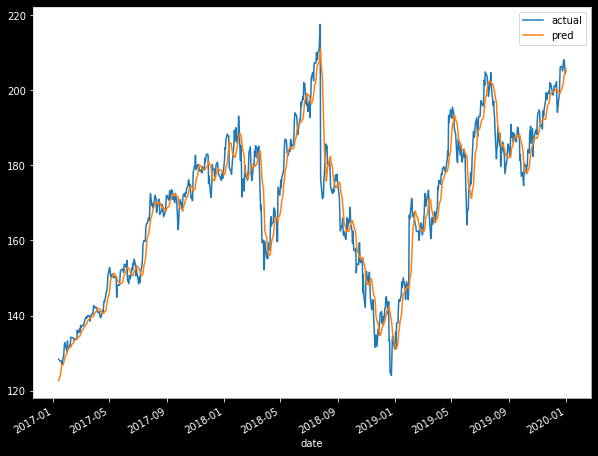

In [ ]:
df_pred = validate(MeanModel(), 'FB')
plot(df_pred)

# Strategy

In [ ]:
class SimpleStrategy:
  """Simple strategy

  If day's predicted change is positive, hold through day.
  If day's predicted change is negative, skip the day.
  """
  def __init__(self, model):
    self.model = model

  def compute_hold(self, ticker):
    df_pred = validate(self.model, ticker)
    df_pred = df_pred.dropna(subset=('actual', 'pred'))
    actual, pred = df_pred['actual'].values, df_pred['pred'].values
    assert len(actual) == len(pred)
    hold = pred[1:] > pred[:-1]
    return pd.DataFrame.from_dict({
        'actual': actual[1:],
        'pred': pred[1:],
        'hold': hold,
    })

def compute_returns(df):
  df = df.copy()
  df.loc[:, 'roi_actual'] = df.actual / df.actual.shift(1)
  df.loc[:, 'roi_pred'] = df.pred / df.pred.shift(1)
  return df

def total_return(df, query=None):
  if query:
    df = df.query(query)
  roi_actual = df.roi_actual.product()
  roi_pred = df.roi_pred.product()
  return roi_actual, roi_pred

def evaluate_models(models, tickers):
  strats = {name: SimpleStrategy(model) for name, model in models.items()}
  df_actual = pd.DataFrame()
  df_pred = pd.DataFrame()
  
  for ticker in tickers:
    for strat_name, strat in strats.items():
      df_hold = strat.compute_hold(ticker)
      df_roi = compute_returns(df_hold)
      
      all = total_return(df_roi)
      hold = total_return(df_roi, 'hold == True')
      not_hold = total_return(df_roi, 'hold == False')

      df_actual.loc[strat_name + ': all', ticker] = all[0]
      df_actual.loc[strat_name + ': hold', ticker] = hold[0]
      df_actual.loc[strat_name + ': !hold', ticker] = not_hold[0]
      df_pred.loc[strat_name + ': all', ticker] = all[1]
      df_pred.loc[strat_name + ': hold', ticker] = hold[1]
      df_pred.loc[strat_name + ': !hold', ticker] = not_hold[1]
  return df_actual, df_pred


In [ ]:
models = {
    'mean': MeanModel(),
    'linear': model,
}
tickers = [
    'FB',
    'GOOG',
    'AAPL',
    'MSFT',
    'SPY',
]

df_actual, df_pred = evaluate_models(models, tickers)
df_actual

,FB,GOOG,AAPL,MSFT,SPY
mean: all,1.605146,1.661699,2.561681,2.661718,1.505768
mean: hold,1.191727,0.858176,1.725185,1.198620,1.311941
mean: !hold,1.346908,1.936316,1.484874,2.220653,1.147746
linear: all,1.605146,1.661699,2.561681,2.661718,1.505768
linear: hold,1.001639,1.032492,2.433386,1.100333,1.288130
linear: !hold,1.602517,1.609406,1.052723,2.419017,1.168961
